# Titanic Data Analysis By Mehdi Jafari

## Introduction

This pronject is anlyzing the demographics and passenger information from 891 of the 2224 passengers and crew on board the Titanic. Here are the variables that I will look at:

1- socioeconomic status  
2- gender  
3- being alone or with family  

I will try to answer the follwoing questions:  

1- Did peopel's socioeconomic help them to get into lifeboat?  
2- How did passengers' gender affect their chance to survive?  
3- what about being alone or with family?  
4- What is to co-relation between the survival and number of family members?  

3- Did socio socio-economic status affect the chance of survival?  
4- Was being in a family helped family members to survive more that the ones traveling alone?  


In [1]:
%matplotlib inline 
import pprint
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os

titanic_df = pd.read_csv('titanic-data.csv')
titanic_df.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


## Data Wrangling

Since count in the column 'Age' is diffrent from other columns, there must be some rows in our dataset with invalid or null age which should be scraped from the dataset that will be used for the rest of this project.


In [2]:
titanic_df = titanic_df[titanic_df.Age > 0]

print len(titanic_df)

714


In [3]:

#lambda function for survival conversion 
SurvivalConversion = lambda survived: 'Survived' if survived == 1 else 'Died'

#lambda function for sex convesion 
SexConversion = lambda sex: 1 if sex == 'male' else 2

#lambda function to return 'With Family' if thet are traveling with their siblings, parents, partners or children 
WithFamilyConversion = lambda sibsp , parch: 'Alone'  if sibsp == 0 and parch == 0 else 'With Family'

#function to convert pClass value based on the documentation
def ConvertPClass(pclass):
    if pclass == 1:
        return 'Upper'
    elif pclass == 2:
        return 'Middle'
    elif pclass == 3:
        return 'Lower'
    else:
        return 'NA'

#returns number of family members on the board
def FamilyCount(sibsp, parch):
    return sibsp + parch

#standardize the value    
def StandardizeColumn(column, value):
    std = column.std()
    mean = column.mean()
    return (value - mean) / std

#adding comuted columns
titanic_df['SexFactor'] = titanic_df['Sex'].apply(SexConversion)
titanic_df['SurvivedFactor'] = titanic_df['Survived'].apply(SurvivalConversion)
titanic_df['PclassFactor'] = titanic_df['Pclass'].apply(ConvertPClass)
titanic_df['WithFamily'] =  titanic_df.apply(lambda row: WithFamilyConversion(row['SibSp'], row['Parch']), axis=1)
titanic_df['FamilyCount'] = titanic_df.apply(lambda row: FamilyCount(row['SibSp'], row['Parch']), axis=1)
titanic_df['ScaledFamilyCount'] = (titanic_df['FamilyCount'] - titanic_df['FamilyCount'].mean()) / titanic_df['FamilyCount'].std(ddof=0)
titanic_df['ScaledAge'] = (titanic_df['Age'] - titanic_df['Age'].mean()) / titanic_df['Age'].std(ddof=0)

titanic_df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,SexFactor,SurvivedFactor,PclassFactor,WithFamily,FamilyCount,ScaledFamilyCount,ScaledAge
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S,1,Died,Lower,With Family,1,0.037783,-0.530377
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C,2,Survived,Upper,With Family,1,0.037783,0.571831
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S,2,Survived,Lower,Alone,0,-0.636641,-0.254825
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S,2,Survived,Upper,With Family,1,0.037783,0.365167
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S,1,Died,Lower,Alone,0,-0.636641,0.365167


## Exploration Phase


### Selected Variables Distribution

Let's start with exploring the destibution of our selected variables.


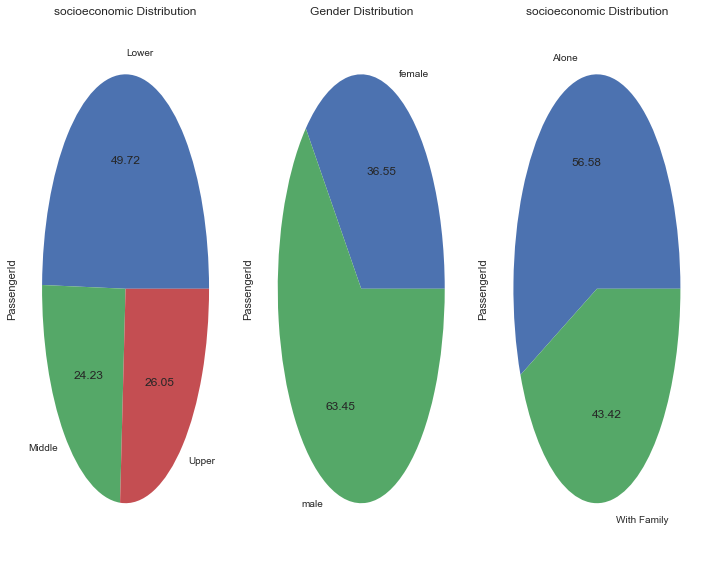

In [4]:
SocioEconomicDistribution = pd.Series(titanic_df.groupby(['PclassFactor']).count()['PassengerId'])
GenderDistribution = pd.Series(titanic_df.groupby(['Sex']).count()['PassengerId'])
WithFamilyDistribution = pd.Series(titanic_df.groupby(['WithFamily']).count()['PassengerId'])

plt.close('all')
fig = plt.figure()

ax1 = plt.subplot2grid((1, 36), (0, 0), colspan=12)
ax2 = plt.subplot2grid((1, 36), (0, 12), colspan=12)
ax3 = plt.subplot2grid((1, 36), (0, 24), colspan=12)

SocioEconomicDistribution.plot.pie(figsize=(10, 8),autopct='%.2f', title="socioeconomic Distribution", ax=ax1)
GenderDistribution.plot.pie(figsize=(10, 8),autopct='%.2f' , title="Gender Distribution", ax=ax2)
WithFamilyDistribution.plot.pie(figsize=(10, 8),autopct='%.2f', title="socioeconomic Distribution", ax=ax3)

plt.tight_layout()

### Question 1: Survival by Gender
As described in the following diagram, children had about 60 percent chance af survival, people from age 10 to 60 had about 40 percent chance and elderly people hace about 20 percent chance of survival. So, there could be a corelation between the age and the survival chance.

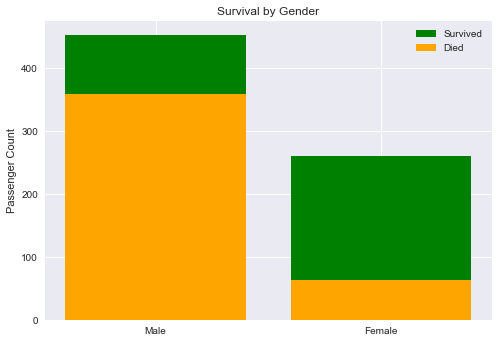

In [5]:
groups = [0,1] 
categoryCount = titanic_df.groupby(['Sex']).count()['PassengerId']
survivalBreakdown = titanic_df.groupby(['SurvivedFactor','Sex']).count()['PassengerId']
totalCount = (categoryCount['male'],categoryCount['female'])
diedCount = (survivalBreakdown['Died']['male'],survivalBreakdown['Died']['female'])

p1 = plt.bar(groups, totalCount, align='center', color='green')
p2 = plt.bar(groups, diedCount, align='center',  color='orange')

plt.xticks(groups, ('Male','Female'))
plt.ylabel('Passenger Count')
plt.title('Survival by Gender')
plt.legend((p1[0],p2[0]),('Survived','Died'))
plt.show()

### Question 1: Survival by Socio-economic status (SES)
 As dipected in the follwing diagram, there could be a corelation between socio-economic status and the survival. About 70 percent of Upper class travelers survicved where as only 25 percent of lower class survived.

0    0.760563
1    0.520231
2    0.344086
dtype: float64


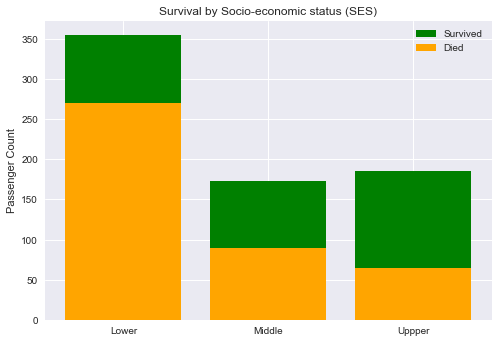

In [6]:
groups = [0,1,2] 
categoryCount = titanic_df.groupby(['PclassFactor']).count()['PassengerId']
survivalBreakdown = titanic_df.groupby(['SurvivedFactor','PclassFactor']).count()['PassengerId']
totalCount = (categoryCount['Lower'],
              categoryCount['Middle'],
              categoryCount['Upper'])
diedCount = (survivalBreakdown['Died']['Lower'],
             survivalBreakdown['Died']['Middle'],
             survivalBreakdown['Died']['Upper'],)

print pd.Series(diedCount)/pd.Series(totalCount)

p1 = plt.bar(groups, totalCount, align='center', color='green')
p2 = plt.bar(groups, diedCount, align='center', color='orange')

plt.xticks(groups, ('Lower','Middle','Uppper'))
plt.ylabel('Passenger Count')
plt.title('Survival by Socio-economic status (SES)')
plt.legend((p1[0],p2[0]),('Survived','Died'))
plt.show()

### Question 2: Survival by Family
 As we can see in the diagram and percisely in the printed values they would have better chance to survice if they were travling with family. 

0    0.678218
1    0.483871
dtype: float64


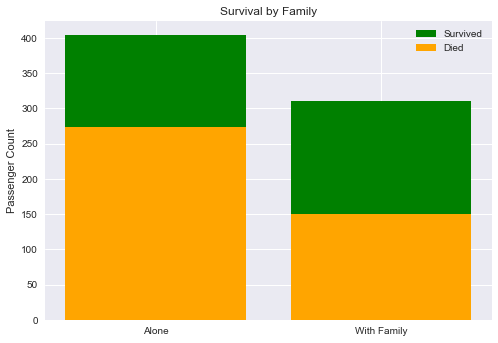

In [7]:
groups = [0,1] 
categoryCount = titanic_df.groupby(['WithFamily']).count()['PassengerId']
survivalBreakdown = titanic_df.groupby(['SurvivedFactor','WithFamily']).count()['PassengerId']
totalCount = (categoryCount['Alone'],categoryCount['With Family'])
diedCount = (survivalBreakdown['Died']['Alone'],survivalBreakdown['Died']['With Family'])

print pd.Series(diedCount)/pd.Series(totalCount)

p1 = plt.bar(groups, totalCount, align='center', color= 'green')
p2 = plt.bar(groups, diedCount, align='center',  color='orange')

plt.xticks(groups, ('Alone','With Family'))
plt.ylabel('Passenger Count')
plt.title('Survival by Family')
plt.legend((p1[0],p2[0]),('Survived','Died'))
plt.show()

### Question 3: Correlation
In this question we study the corelation between age and FamilyCount

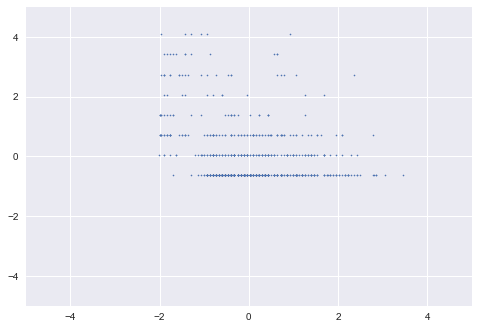

-0.301913959192


In [9]:
standardAgeMean = titanic_df['ScaledAge'].mean()
standardAgeStd = titanic_df['ScaledAge'].std()
lx = standardAgeMean-(5*standardAgeStd)
hx = standardAgeMean+(5*standardAgeStd)
standardFareMean = titanic_df['ScaledFamilyCount'].mean()
standardFareStd = titanic_df['ScaledFamilyCount'].std()
ly = standardFareMean-(5*standardFareStd)
hy = standardFareMean+(5*standardFareStd)
plt.scatter (titanic_df['ScaledAge'], titanic_df['ScaledFamilyCount'], s=1.5)
plt.axis([lx, hx, ly, hy])
plt.show()
print (titanic_df['ScaledAge'] * titanic_df['ScaledFamilyCount']).mean()

## Conclusion
As one would expect, the study shows that women and pe.